In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
import time
import pandas
import matplotlib.pyplot as plt

In [ ]:
def partition(X, T, n_folds, random_shuffle=True):
    np.random.seed(42)
    rows = np.arange(X.shape[0])
    np.random.shuffle(rows)
    X = X[rows, :]
    T = T[rows, :]
    
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )
    len(folds), len(folds[0]), folds[0][0].shape, folds[0][1].shape
    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]])
    Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape

    return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

In [ ]:
def confusion_matrix(Y_classes, T):
  class_names=np.unique(T)
  table = []
  for true_class in class_names:
    row = []
    for predicted_class in class_names:
        row.append(100 * np.mean(Y_classes[T == true_class] == predicted_class))
    table.append(row)
    
  print(f'Test percent correct {np.mean(Y_classes == T) * 100:.2f}') 

  return pandas.DataFrame(table, index=class_names, columns=class_names)

In [ ]:
%%writefile optimizers.py
import numpy as np

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Overwriting optimizers.py


In [ ]:
import optimizers
import sys  

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views



    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'



    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'
    def makeIndicatorVars(self, T):
          if T.ndim == 1:
              T = T.reshape((-1, 1))
          retT = (T == np.unique(T)).astype(int)
          return retT
          
    def softmax (self, X):
        fs = np.exp(X)  
        denom = np.sum(fs, axis=1).reshape((-1, 1))
        gs = fs / (denom + sys.float_info.epsilon)
        return gs

    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):

        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        X = (X - self.Xmeans) / self.Xstds
        self.TtrainI = self.makeIndicatorVars(T)
        self.uniqueT=np.unique(T)
        optimizer = optimizers.Optimizers(self.all_weights)


        error_convert_f = lambda nll: (np.exp(-nll))

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, self.TtrainI], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, self.TtrainI], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    def error_f(self, X, T):
        temp = self.forward_pass(X)
        Y = self.softmax(temp[-1])
        return - np.mean((T * np.log(Y)))

    def gradient_f(self, X, T):
        Y = self.softmax(self.Ys[-1])
        delta = (Y - T) / (T.shape[0] * T.shape[1])
        n_layers = len(self.n_hiddens_per_layer) + 1
        for layeri in range(n_layers - 1, -1, -1):
              self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
              self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
              if self.activation_function == 'relu':
                  delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
              else:
                  delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        Xtest = ((X - self.Xmeans)/self.Xstds)
        temp = self.forward_pass(Xtest)
        logregOutput = self.softmax(temp[-1])
        predictedTrain = np.argmax(logregOutput,axis=1)
        result = np.array(list(map(lambda x: [self.uniqueT[x].astype(int)] , predictedTrain)))
        return result , logregOutput

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Team_Project_Final_Dataset.csv to Team_Project_Final_Dataset (2).csv


In [ ]:
FileData = pandas.read_csv('Team_Project_Final_Dataset.csv', delimiter=',',
                          names=('Date', '# of Tweets', '# of +Tweets','# of -Tweets',
                                 '# of +Articles', '# of -Articles', '% Diff Dow Jones',
                                 '% Diff Tesla'))
FileData = FileData.drop([0])
FileData

,Date,# of Tweets,# of +Tweets,# of -Tweets,# of +Articles,# of -Articles,% Diff Dow Jones,% Diff Tesla
1,6/28/2013,109.0,99.0,83.0,NaN,NaN,0.000000,1
2,6/29/2013,NaN,NaN,NaN,NaN,NaN,-0.002772,1
3,6/30/2013,23.0,20.0,13.0,NaN,NaN,-0.002772,1
4,7/15/2013,525.0,791.0,620.0,NaN,NaN,0.001524,7
5,7/15/2013,46.0,50.0,36.0,NaN,NaN,0.001524,7
...,...,...,...,...,...,...,...,...
4198,10/14/2011,NaN,NaN,NaN,NaN,NaN,0.010974,5
4199,10/15/2011,NaN,NaN,NaN,NaN,NaN,-0.007141,5
4200,10/16/2011,NaN,NaN,NaN,NaN,NaN,-0.007141,5
4201,3/22/2012,3.0,3.0,4.0,NaN,NaN,-0.009464,5


In [ ]:
#FileData = FileData.dropna()
FileData

,Date,# of Tweets,# of +Tweets,# of -Tweets,# of +Articles,# of -Articles,% Diff Dow Jones,% Diff Tesla
1,6/28/2013,109.0,99.0,83.0,NaN,NaN,0.000000,0
2,6/29/2013,NaN,NaN,NaN,NaN,NaN,-0.002772,0
3,6/30/2013,23.0,20.0,13.0,NaN,NaN,-0.002772,0
4,7/15/2013,525.0,791.0,620.0,NaN,NaN,0.001524,4
5,7/15/2013,46.0,50.0,36.0,NaN,NaN,0.001524,4
...,...,...,...,...,...,...,...,...
4198,10/14/2011,NaN,NaN,NaN,NaN,NaN,0.010974,4
4199,10/15/2011,NaN,NaN,NaN,NaN,NaN,-0.007141,4
4200,10/16/2011,NaN,NaN,NaN,NaN,NaN,-0.007141,4
4201,3/22/2012,3.0,3.0,4.0,NaN,NaN,-0.009464,4


In [ ]:
#FileData['# of Tweets'] = FileData['# of Tweets'].astype(float)
#FileData['# of +Tweets'] = FileData['# of +Tweets'].astype(float)
#FileData['# of -Tweets'] = FileData['# of -Tweets'].astype(float)
#FileData['# of +Articles'] = FileData['# of +Articles'].astype(float)
#FileData['# of -Articles'] = FileData['# of -Articles'].astype(float)
#FileData['% Diff Dow Jones'] = FileData['% Diff Dow Jones'].astype(float)
#FileData['% Diff Tesla'] = FileData['% Diff Tesla'].astype(int)
Orig_FileData=FileData
FileData=FileData.replace({'% Diff Tesla': {1: 0,2: 0,3: 0,5: 4,6: 4,7: 4}})
FileData

NameError: ignored

In [ ]:
dates = FileData.iloc[:,1:-1].to_numpy()
X = FileData.iloc[:,1:-1].to_numpy()
T = FileData.iloc[:,-1:].to_numpy()
Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X, T, 10, random_shuffle=True)
dates2 = Orig_FileData.iloc[:,1:-1].to_numpy()
X2 = Orig_FileData.iloc[:,1:-1].to_numpy()
T2 = Orig_FileData.iloc[:,-1:].to_numpy()
Xtrain2, Ttrain2, Xvalidate2, Tvalidate2, Xtest2, Ttest2 = partition(X2, T2, 10, random_shuffle=True)


In [ ]:
nnets=[]
for i in [[10],[100],[10,20,10],[10,100],[100,10],[100,10,100],[100,200,100],[10,100,10],[20,50,100,50,20],[10,50,100,200,100,50,10],[200,100,50,10,50,100,200]]:
  nnets.append(NeuralNetwork(Xtrain.shape[1], i, 2))
for nnet in nnets:
  nnet.train(Xtrain, Ttrain, 5000, .0005, method='adam', verbose=True)
  print(nnet)

Adam: Epoch 500 Error=0.73109
Adam: Epoch 1000 Error=0.75918
Adam: Epoch 1500 Error=0.77783
Adam: Epoch 2000 Error=0.79077
Adam: Epoch 2500 Error=0.80102
Adam: Epoch 3000 Error=0.80912
Adam: Epoch 3500 Error=0.81737
Adam: Epoch 4000 Error=0.82477
Adam: Epoch 4500 Error=0.83124
Adam: Epoch 5000 Error=0.83840
NeuralNetwork(6, [10], 2, 'tanh') trained for 5000 epochs, final training error 0.8384
Adam: Epoch 500 Error=0.76161
Adam: Epoch 1000 Error=0.79626
Adam: Epoch 1500 Error=0.82693
Adam: Epoch 2000 Error=0.85433
Adam: Epoch 2500 Error=0.87750
Adam: Epoch 3000 Error=0.89738
Adam: Epoch 3500 Error=0.91640
Adam: Epoch 4000 Error=0.93257
Adam: Epoch 4500 Error=0.94527
Adam: Epoch 5000 Error=0.95502
NeuralNetwork(6, [100], 2, 'tanh') trained for 5000 epochs, final training error 0.9550
Adam: Epoch 500 Error=0.74758
Adam: Epoch 1000 Error=0.79969
Adam: Epoch 1500 Error=0.85460
Adam: Epoch 2000 Error=0.89731
Adam: Epoch 2500 Error=0.93062
Adam: Epoch 3000 Error=0.96473
Adam: Epoch 3500 Error

In [ ]:
for nnet in nnets:
  print(nnet)
  Y_classes, Y_probs = nnet.use(Xtest)
  print("test")
  confusion_matrix(Y_classes, Ttest)
  Y_classes, Y_probs = nnet.use(Xvalidate)
  print("validate")
  confusion_matrix(Y_classes, Tvalidate)

NeuralNetwork(6, [10], 2, 'tanh') trained for 5000 epochs, final training error 0.8384
test
Test percent correct 71.43
validate
Test percent correct 64.29
NeuralNetwork(6, [100], 2, 'tanh') trained for 5000 epochs, final training error 0.9550
test
Test percent correct 60.71
validate
Test percent correct 67.86
NeuralNetwork(6, [10, 20, 10], 2, 'tanh') trained for 5000 epochs, final training error 0.9925
test
Test percent correct 71.43
validate
Test percent correct 60.71
NeuralNetwork(6, [10, 100], 2, 'tanh') trained for 5000 epochs, final training error 0.9972
test
Test percent correct 75.00
validate
Test percent correct 71.43
NeuralNetwork(6, [100, 10], 2, 'tanh') trained for 5000 epochs, final training error 0.9775
test
Test percent correct 71.43
validate
Test percent correct 67.86
NeuralNetwork(6, [100, 10, 100], 2, 'tanh') trained for 5000 epochs, final training error 0.9996
test
Test percent correct 67.86
validate
Test percent correct 64.29
NeuralNetwork(6, [100, 200, 100], 2, 'tan

In [ ]:
Y_classes, Y_probs = nnets[3].use(Xtest)
print("test")
confusion_matrix(Y_classes, Ttest)

test
Test percent correct 75.00


,0,4
0,80.000000,20.000000
4,27.777778,72.222222


In [ ]:
Y_classes, Y_probs = nnets[10].use(Xtest)
confusion_matrix(Y_classes, Ttest)

Test percent correct 35.71


,0,4
0,100.0,0.0
4,100.0,0.0


In [ ]:
nnets2=[]
for i in [[10],[100],[10,20,10],[10,100],[100,10],[100,10,100],[100,200,100],[10,100,10],[20,50,100,50,20],[10,50,100,200,100,50,10],[200,100,50,10,50,100,200]]:
  nnets2.append(NeuralNetwork(Xtrain2.shape[1], i, 7))
for nnet in nnets2:
  nnet.train(Xtrain2, Ttrain2, 5000, .0005, method='adam', verbose=True)
  print(nnet)

Adam: Epoch 500 Error=0.79886
Adam: Epoch 1000 Error=0.80704
Adam: Epoch 1500 Error=0.81466
Adam: Epoch 2000 Error=0.82353
Adam: Epoch 2500 Error=0.83172
Adam: Epoch 3000 Error=0.83811
Adam: Epoch 3500 Error=0.84318
Adam: Epoch 4000 Error=0.84779
Adam: Epoch 4500 Error=0.85146
Adam: Epoch 5000 Error=0.85547
NeuralNetwork(6, [10], 7, 'tanh') trained for 5000 epochs, final training error 0.8555
Adam: Epoch 500 Error=0.81979
Adam: Epoch 1000 Error=0.84946
Adam: Epoch 1500 Error=0.87352
Adam: Epoch 2000 Error=0.89015
Adam: Epoch 2500 Error=0.90236
Adam: Epoch 3000 Error=0.91421
Adam: Epoch 3500 Error=0.92611
Adam: Epoch 4000 Error=0.93676
Adam: Epoch 4500 Error=0.94607
Adam: Epoch 5000 Error=0.95445
NeuralNetwork(6, [100], 7, 'tanh') trained for 5000 epochs, final training error 0.9544
Adam: Epoch 500 Error=0.80193
Adam: Epoch 1000 Error=0.80812
Adam: Epoch 1500 Error=0.81297
Adam: Epoch 2000 Error=0.81917
Adam: Epoch 2500 Error=0.82541
Adam: Epoch 3000 Error=0.83186
Adam: Epoch 3500 Error

In [ ]:
for nnet in nnets2:
  print(nnet)
  Y_classes, Y_probs = nnet.use(Xtest2)
  print("test")
  confusion_matrix(Y_classes, Ttest2)
  Y_classes, Y_probs = nnet.use(Xvalidate2)
  print("validate")
  confusion_matrix(Y_classes, Tvalidate2)
Y_classes, Y_probs = nnets2[0].use(Xtest2)
print("test")
confusion_matrix(Y_classes, Ttest2)

NeuralNetwork(6, [10], 7, 'tanh') trained for 10000 epochs, final training error 0.8804
test
Test percent correct 50.00
validate
Test percent correct 50.00
NeuralNetwork(6, [100], 7, 'tanh') trained for 10000 epochs, final training error 0.9944
test
Test percent correct 46.43
validate
Test percent correct 46.43
NeuralNetwork(6, [10, 20, 10], 7, 'tanh') trained for 10000 epochs, final training error 0.9457
test
Test percent correct 53.57
validate
Test percent correct 42.86
NeuralNetwork(6, [10, 100], 7, 'tanh') trained for 10000 epochs, final training error 0.9998
test
Test percent correct 46.43
validate
Test percent correct 42.86
NeuralNetwork(6, [100, 10], 7, 'tanh') trained for 10000 epochs, final training error 0.9230
test
Test percent correct 46.43
validate
Test percent correct 39.29
NeuralNetwork(6, [100, 10, 100], 7, 'tanh') trained for 10000 epochs, final training error 1.0000
test
Test percent correct 39.29
validate
Test percent correct 35.71
NeuralNetwork(6, [100, 200, 100], 7

,2,3,4,5,6
2,80.000000,0.000000,0.0,20.000000,0.0
3,0.000000,40.000000,0.0,60.000000,0.0
4,0.000000,25.000000,25.0,50.000000,0.0
5,27.272727,9.090909,0.0,63.636364,0.0
6,0.000000,0.000000,0.0,100.000000,0.0


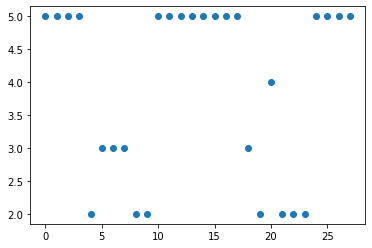

In [ ]:
plt.scatter(range(Y_classes.size),Y_classes)


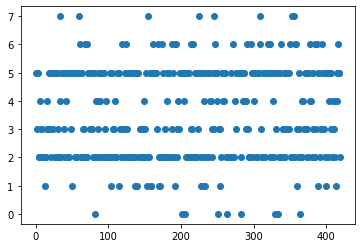

In [ ]:
plt.scatter(range(Ttest.size),Ttest)

In [ ]:
unique, counts = np.unique(T, return_counts=True)
dict(zip(unique, counts))

{0: 2284, 4: 1918}

In [ ]:
print(T.size)

4202
